# xforms Demo

This notebook demonstrates the use of xforms for generating models that are easy to reload.

In [1]:
import logging
from pathlib import Path

import nems.db as db
import nems.modelspec as ms
import nems.recording as recording
import nems.uri
import nems.xforms as xforms

[nems.configs.defaults INFO] Saving log messages to /tmp/nems\NEMS 2020-05-28 141002.log


## Configuration

In [2]:
# get the data and results paths
results_dir = nems.get_setting('NEMS_RESULTS_DIR')
signals_dir = nems.get_setting('NEMS_RECORDINGS_DIR')

In [3]:
# download some demo data
recording.get_demo_recordings(signals_dir)
datafile = Path(signals_dir) / 'TAR010c-18-1.pkl'

## Data Loading and Preprocessing

In [4]:
load_command = 'nems.demo.loaders.demo_loader'
expt_id = 'TAR010c'
batch = 271
cell_id = 'TAR010c-18-1'

In [5]:
modelspec_name = 'dlog-wc.18x1.g-fir.1x15-lvl.1-dexp.1'

## Generate the Modelspec

Each item in the xform spec is a call to a function along with the arguments for that function.

In [6]:
xfspec = []

In [7]:
# load from external format
xfspec.append(['nems.xforms.load_recording_wrapper', 
               {'load_command': load_command,
                'exptid': expt_id,
                'datafile': str(datafile)
               }])

In [8]:
# split the data into est and val
xfspec.append(['nems.xforms.split_by_occurrence_counts',
               {'epoch_regex': '^STIM_'}])

In [9]:
xfspec.append(['nems.xforms.average_away_stim_occurrences', {}])

In [10]:
meta = {'cellid': cell_id, 'batch': batch, 'modelname': modelspec_name, 'recording': expt_id}

xfspec.append(['nems.xforms.init_from_keywords',
               {'keywordstring': modelspec_name,
                'meta': meta
               }])

In [11]:
# init, then fit
xfspec.append(['nems.xforms.fit_basic_init', {}])
xfspec.append(['nems.xforms.fit_basic', {'tolerance': 1e-6}])

In [12]:
xfspec.append(['nems.xforms.predict', {}])

In [13]:
# test prediction then visualize
xfspec.append(['nems.analysis.api.standard_correlation', {},
               ['est', 'val', 'modelspec', 'rec'], ['modelspec']])
xfspec.append(['nems.xforms.plot_summary', {}])

## Run the Analysis

[nems.xforms INFO] Evaluating: nems.xforms.load_recording_wrapper
[nems.xforms INFO] Loading cached file C:\Users\Alex\PycharmProjects\NEMS\recordings\TAR010c_afb264b3db970ec890e04c727e612c1cbfaced62.tgz
[nems.xforms INFO] Evaluating: nems.xforms.split_by_occurrence_counts
[nems.xforms INFO] Evaluating: nems.xforms.average_away_stim_occurrences
[nems.xforms INFO] Evaluating: nems.xforms.init_from_keywords
[nems.initializers INFO] kw: dlog
[nems.initializers INFO] kw: wc.18x1.g
[nems.initializers INFO] kw: fir.1x15
[nems.initializers INFO] kw: lvl.1
[nems.initializers INFO] kw: dexp.1
[nems.initializers INFO] Setting modelspec[0] input to stim
[nems.xforms INFO] Evaluating: nems.xforms.fit_basic_init
[nems.initializers INFO] prefit_LN parameters: tol=3.16e-06 max_iter=1500
[nems.initializers INFO] target_module: ['levelshift', 'relu'] found at modelspec[3].
[nems.initializers INFO] Mod 3 (nems.modules.levelshift.levelshift) initializing level to resp mean 0.207
[nems.initializers INFO] 

bin range: 0-500


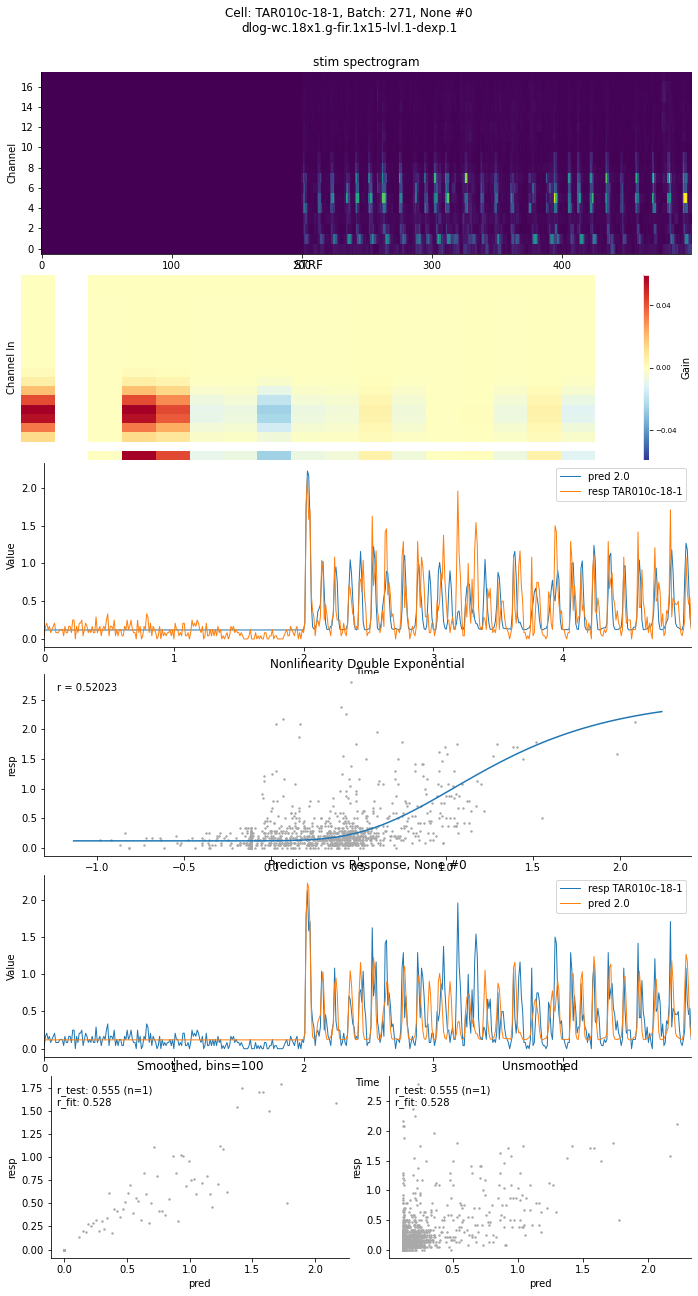

In [14]:
ctx = {}
for xfa in xfspec:
    ctx = xforms.evaluate_step(xfa, ctx)

## Saving Results

In [15]:
# get a unique dir to save the modelspec to
destination = Path(results_dir) / str(batch) / xforms.get_meta(ctx)['cellid'] / ms.get_modelspec_longname(ctx['modelspec'])
destination = str(destination)

In [16]:
xforms.save_analysis(destination,
                     recording=ctx['rec'],
                     modelspec=ctx['modelspec'],
                     xfspec=xfspec,
                     figures=ctx['figures'],
                     log='NO LOG')

{'savepath': 'C:\\Users\\Alex\\PycharmProjects\\NEMS\\results\\271\\TAR010c-18-1\\TAR010c.dlog_wc.18x1.g_fir.1x15_lvl.1_dexp.1.fit_basic.2020-05-28T211146/'}

In [ ]:
# save summary of results to a database
modelspec = ctx['modelspec']
modelspec.meta['modelpath'] = destination
modelspec.meta['figurefile'] = destination + 'figure.0000.png'
db.update_results_table(modelspec)